In [1]:
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
# import sys
# sys.path.append('.')

# from stringUtils import *

from scipy import integrate
# from itertools import combinations
from math import factorial

%matplotlib inline

In the [Chernoff et al 2020 paper](https://ui.adsabs.harvard.edu/abs/2020MNRAS.491..596C/abstract) equation 12 gives the microlensing rate per star per second: 

$\frac{\Gamma}{N_\star} = \int_0^D dr' dl \left(\frac{dn}{dl}\right)'\langle \frac{dA_\perp}{dt} \rangle$.

I use $\langle \frac{dA_\perp}{dt} \rangle = 0.2 lc$.

I take $\left(\frac{dn}{dl}\right)'$ to be $\frac{1}{l}\mathcal{F}(r')\,\mathcal{G}\,\left(\frac{dn}{d\ln{l}}\right)_\text{base}$, as in Equation 3, which invokes clustering via $\mathcal{F}$. In their paper, $\mathcal{G} = 10^2$ as stated in the first paragraph on page 598, and equation 1 states that:

$\left(\frac{dn}{d\ln{l}}\right)_\text{base} = 1.15 \times 10^{-6} \frac{x}{(1+x)^{5/2}} \frac{f_{0.2}\alpha_{0.1}^{1/2}}{(\Gamma_{50}\mu_{-13})^{3/2}} \text{kpc}^{-3}$,

where $\mu_{-13} = \frac{G \mu}{c^2} \times 10^{13}$, $x = \frac{l}{l_g}$, $l_g = 0.0206 \, \Gamma_{50} \, \mu_{-13}$ pc, and $\Gamma_{50} = f_{0.2} = \alpha_{0.1} = 1$. The clustering enhancement 

$\mathcal{F}(r) = \max \left(\beta(\mu)\mathcal{E}(r), 1\right) = \max\left(\beta(\mu) \frac{\rho_{DM}(r)}{\Omega_{DM} \rho_{\text{crit}}}, 1\right)$ 

is defined in the second paragraph on the right side of page 599. $\max$ is used to ensure that $\mathcal{F} \geq 1$ always. The functional form of $\beta(\mu)$ is given in Appendix F of [Chernoff and Tye's 2018 paper](https://arxiv.org/pdf/1712.05060.pdf). $\mathcal{E} = \frac{\rho_{DM}(r)}{\Omega_{DM} \rho_{\text{crit}}}$ is defined in equation 5: 

$ \rho_{\text{MW - M31}} = \begin{cases}
\frac{A}{r^{9/4}} & 0 < r < r_1 \\ 
\frac{2^{3/4}A}{(B-r)^{9/4}} & r_1 < r < B
\end{cases} $

where $A = 1.15 \times 10^9 M_\odot / \text{kpc}^{3/4}$, $r_1 = 345$ kpc, and $B = 780$ kpc. I use $\Omega_{DM} = 1/4$ and $\rho_{\text{crit}} = 3 H_0^2/8\pi G$. Finally, I place the observer 8 kpc from the Milky Way center and the source 8 kpc in front of the center of M31, as indicated in table 1 of the 2020 paper.

Combining all this gives:

$\frac{\Gamma}{N_\star} = \int_8^{772}dr' \int_0^\infty dl \, \frac{1}{l}\, \mathcal{F}(r) \, \mathcal{G}\, 1.15 \times 10^{-6} \, \frac{x}{(1+x)^{5/2}} \, \frac{f_{0.2}\alpha_{0.1}^{1/2}}{(\Gamma_{50}\mu_{-13})^{3/2}} \, \text{kpc}^{-3}  lc$

Cancelling the factors of $l$ and using $dl = l_g dx$ gives:

$\frac{\Gamma}{N_\star} = \int_8^{772}dr' \int_0^\infty dx l_g \, c \, \mathcal{F}(r) \, \mathcal{G}\, 1.15 \times 10^{-6} \, \frac{x}{(1+x)^{5/2}} \, \frac{f_{0.2}\alpha_{0.1}^{1/2}}{(\Gamma_{50}\mu_{-13})^{3/2}} \, \text{kpc}^{-3} $.

the $x$ integral gives:

$\int_0^\infty dx \frac{x}{(1+x)^{(5/2)}} = 4/3$.

Finally we have

$\frac{\Gamma}{N_\star} = l_g \, c \, 
\mathcal{G} \, 1.15 \times 10^{-6} \, \frac{4}{3} \, \frac{f_{0.2}\alpha_{0.1}^{1/2}}{(\Gamma_{50}\mu_{-13})^{3/2}} \, \int_8^{772} dr \mathcal{F}(r) \, \text{kpc}^{-3} $

In [55]:
class EventRateCalculator():
    _f02 = 1
    _a01 = 1
    _gamma50 = 1

    @property
    def f02(self):
        return self._f02

    @property
    def a01(self):
        return self._a01

    @property
    def gamma50(self):
        return self._gamma50

    def set_f02(self, f02):
        self._f02 = f02

    def set_a01(self, a01):
        self._a01 = a01

    def set_gamma50(self, gamma50):
        self._gamma50 = gamma50

    def __init__(self, configDict):
        self.tensions = configDict.get("tensions", np.logspace(-15, -8, num=8))
        self.curlyG = configDict.get("curlyG", 1e2)
        self.dmHaloA = configDict.get("dmHaloA", 1.15e9 * u.solMass / u.kpc**(3/4))
        self.dmHaloR1 = configDict.get("dmHaloR1", 345 * u.kpc)
        self.dmHaloC = configDict.get("dmHaloC", 2**(3/4))
        self.hostGalaxyCenter = configDict.get("hostGalaxyCenter", np.array([780, 0]) * u.kpc)
        self.observerGalaxyCenter = configDict.get("observerGalaxyCenter", np.array([0, 0]) * u.kpc)
        self.observerPosition = configDict.get("observerPosition", np.array([8, 0]) * u.kpc)
        self.sourcePosition = configDict.get("sourcePosition",
                                             self.hostGalaxyCenter + np.array([0, 8]) * u.kpc)
        self.impactParameter = configDict.get("impactParameter", np.array([0, 0]) * u.kpc)

        self.results = dict(eventRates = None,
                            dmRho = None,
                            lineOfSight = None,
                            enhancementFactor = None,
                            rStepSize = None)

    @staticmethod
    def _foo(y):
        return -0.337 - (0.064 * y**2)

    def betaOfMu(self):
        return 10**self._foo(np.log10(self.tensions * 1e15))

    def _calculateEnhancementFactor(self):
        littleHubble = 0.7
        bigHubble = littleHubble * 100 * u.km / u.s / u.Mpc
        newtonG = 6.674e-11 * u.newton * u.m**2 / u.kg**2
        rhoCritical = 3 * bigHubble**2 / (8 * np.pi * newtonG)
        omegaDM = 1/4
        overdensityDM = self.results["dmRho"] / (omegaDM * rhoCritical)
        betas = self.betaOfMu()
        # Column of betas to take advantage of python broadcasting
        betas = betas.reshape(len(betas), 1)

        # tempF can have values less than 1
        tempF = (betas * overdensityDM).decompose()

        # invoking np.where so the enhancement is never less than homogeneous limit (ie 1)
        self.results["enhancementFactor"] = np.where(tempF > 1, tempF, 1)

    def calculate(self, nSteps=10000):
        mu13 = self.tensions * 1e13
        speedOfLight = 2.98e8 * u.m / u.s
        xIntegral = 4/3
        f02 = self.f02
        a01 = self.a01
        gamma50 = self.gamma50
        lg = 0.0206 * gamma50 * mu13 * u.pc

        self._modelDMRho(nSteps=nSteps)
        self._calculateEnhancementFactor()

        # Integrate F(r)dr
        enhancementIntegral = integrate.trapz(self.results["enhancementFactor"],
                                              axis=1, dx=self.results["rStepSize"])
        eventRates = (0.2 * lg * speedOfLight * self.curlyG * 1.15e-6 * xIntegral
                     * (f02 * np.sqrt(a01) / (gamma50 * mu13)**(3/2)) *
                     enhancementIntegral * u.kpc**(-3))
        self.results["eventRates"] = eventRates

    def _modelDMRho(self, nSteps=10000):
        hostGalaxyCenter = self.hostGalaxyCenter
        impactParameter = self.impactParameter
        observerPosition = self.observerPosition
        sourcePosition = self.sourcePosition
        r1 = self.dmHaloR1
        dmHaloA = self.dmHaloA
        dmHaloC = self.dmHaloC

        # Scoot the hostGalaxy along y axis to avoid diverging center if needed
        hostGalaxyCenterPrime = (hostGalaxyCenter + impactParameter).reshape(2, 1)
        self.results["lineOfSight"] = np.array([np.linspace(observerPosition[0],
                                                            sourcePosition[0],
                                                            num=nSteps),
                                                np.linspace(observerPosition[1],
                                                            sourcePosition[1],
                                                            num=nSteps)]) * u.kpc

        r = self.results["lineOfSight"]
        # Norm each vector
        rNorm = np.linalg.norm(r, axis=0)
        self.results["rStepSize"] = np.linalg.norm(r[:, 1] - r[:, 0])

        # rPrime is vector from MW center ([0, 0]) when within r1,
        # vector from hostGalaxyCenterPrime otherwise
        rPrime = np.where(rNorm < r1, r, r - hostGalaxyCenterPrime)
        rPrimeNorm = np.linalg.norm(rPrime, axis=0)
        self.results["dmRho"] = np.where(rNorm < r1, dmHaloA / rPrimeNorm**(9/4),
                                         dmHaloC * dmHaloA / rPrimeNorm**(9/4))

class ExperimentExpectationsCalculator():
    def __init__(self, experimentParameters, tensions, eventRates):
        self.observingHoursPerNight = experimentParameters.get("observingHoursPerNight", 8 * u.hr)
        self.filters = experimentParameters.get("filters", ["u", "g", "r", "i", "z", "y"])
        self.visitsInEachFilter = experimentParameters.get("visitsInEachFilter",
                                                           np.array([45, 67, 183, 191, 167, 168]))
        self.detectionThreshold = experimentParameters.get("detectionThreshold", 0.9)
        self.experimentDuration = experimentParameters.get("experimentDuration", 10 * u.yr)
        self.exposureTime = experimentParameters.get("exposureTime", 30 * u.s)
        self.readoutTime = experimentParameters.get("readoutTime", 2 * u.s)
        self.sourceDistance = experimentParameters["sourceDistance"]
        self.tensions = tensions
        self.eventRates = eventRates
        self.results = dict(observableWindowDurations = None,
                            probeableTensions = None,
                            eventProbabilities = None,
                            atLeastOneImageProbabilities = None,
                            detectionProbabilities = None,
                            nStarsRequired = None)
        
    def calculate(self, stringTheta=np.pi/4, exclusionThreshold=1e-5):
        newtonG = 6.674e-11 * u.newton * u.m**2 / u.kg**2
        speedOfLight = 2.98e8 * u.m / u.s
        deficitAngles = 8 * np.pi * self.tensions / 2
        internalMotionRMS = speedOfLight / 2
        maxLensingTimes = self.sourceDistance * deficitAngles * np.sin(stringTheta) / internalMotionRMS
        
        nVisitsAll = self.visitsInEachFilter.sum()
        surveyDuration = self.experimentDuration * self.observingHoursPerNight / (24 * u.hr)
        visitTime = self.exposureTime + self.readoutTime

        observableWindowDurations = (maxLensingTimes + (1 - 2 * self.detectionThreshold)
                                     * self.exposureTime).decompose()
        probeable = np.logical_and(observableWindowDurations > 0,
                                   maxLensingTimes < self.experimentDuration)
        probeableTensions = self.tensions[probeable]
        observableWindowDurations = observableWindowDurations[probeable]
        averageObservableTime = observableWindowDurations * self.observingHoursPerNight / (24 * u.hr)

        lam = (self.eventRates[probeable] * self.experimentDuration).decompose()
        eventProbabilities = 1 - np.exp(-lam)
        
        unlensedTimeInYrs = (surveyDuration - averageObservableTime).to(u.yr).value
        visitTimeInYrs = visitTime.to(u.yr).value
        surveyDurationInYrs = surveyDuration.to(u.yr).value
        missEventProbabilitiesJthExposure = np.array([((unlensedTimeInYrs - j * visitTimeInYrs) / 
                                                       (surveyDurationInYrs - j * visitTimeInYrs))
                                                      for j in range(nVisitsAll)])
        missEventProbabilitiesJthExposure = np.where(missEventProbabilitiesJthExposure > 0,
                                                     missEventProbabilitiesJthExposure, 0)
        missEventProbabilities = np.prod(missEventProbabilitiesJthExposure, axis=0)
        
        atLeastOneImageProbabilities = 1 - missEventProbabilities
        detectionProbabilities = eventProbabilities * atLeastOneImageProbabilities
        nStarsRequired = np.log(exclusionThreshold) / np.log(1 - detectionProbabilities)

#         probabilitiesOfMissingEventPlanar = np.exp(np.sum(np.log([unlensedTimeInYrs - j * 
#                                                                   tVisitInYr for j in range(nVisitsAll)]), axis=0)
#                                                    - nVisitsAll * np.log(tSurveyInYr))

        
        self.results["observableWindowDurations"] = observableWindowDurations
        self.results["probeableTensions"] = probeableTensions
        self.results["eventProbabilities"] = eventProbabilities
        self.results["atLeastOneImageProbabilities"] = atLeastOneImageProbabilities
        self.results["detectionProbabilities"] = detectionProbabilities
        self.results["nStarsRequired"] = nStarsRequired
        
def calculateHaloValues(hostGalaxyDistance, galaxyMassRatio):
    haloR1 = (galaxyMassRatio**(1/3) / (1 + galaxyMassRatio**(1/3))) * hostGalaxyDistance
    haloC = ((hostGalaxyDistance - haloR1) / haloR1)**(9/4)
    return haloR1, haloC
        
# def filterTupleToVector(filterTuple, nFilters):
#     z = np.zeros(nFilters)
#     np.put(z, filterTuple, 1)
#     return z

# def multinomialPDF(x, p):
#     n = x.sum()
#     return (factorial(n) / (np.prod([factorial(xx) for xx in x]))) * np.prod(np.power(p, x))



In [56]:
planarConfig = dict(tensions = np.logspace(-15, -8, num=8),
                    curlyG = 1e2,
                    dmHaloA = 1.15e9 * u.solMass / u.kpc**(3/4),
                    dmHaloC = 2**(3/4),
                    dmHaloR1 = 345 * u.kpc,
                    hostGalaxyCenter = np.array([780, 0]) * u.kpc,
                    observerPosition = np.array([8, 0]) * u.kpc,
                    sourcePosition = np.array([780, 0]) * u.kpc + np.array([0, 8]) * u.kpc
                    )

behindConfig = planarConfig.copy()
behindConfig["impactParameter"] = np.array([0, 0.1]) * u.kpc
behindConfig["sourcePosition"] = behindConfig["hostGalaxyCenter"] + np.array([8, 0]) * u.kpc

centerToCenterConfig = planarConfig.copy()
centerToCenterConfig["observerPosition"] = np.array([0, 0]) * u.kpc
centerToCenterConfig["sourcePosition"] = centerToCenterConfig["hostGalaxyCenter"]

planarEventRateCalculator = EventRateCalculator(planarConfig)
behindEventRateCalculator = EventRateCalculator(behindConfig)
centerToCenterEventRateCalculator = EventRateCalculator(centerToCenterConfig)

nSteps = 100000
planarEventRateCalculator.calculate(nSteps=nSteps)
behindEventRateCalculator.calculate(nSteps=nSteps)
centerToCenterEventRateCalculator.calculate(nSteps=nSteps)

# Values from table C1 of the 2020 paper
tObs = 1 * u.yr
tableC1PlanarResults = np.array([9.66e-6, 2.64e-6, 5.36e-7, 8.11e-8, 
                                 9.14e-9, 7.67e-10, 1.51e-12, np.nan])
tableC1BackResults = np.array([2.46e-3, 6.72e-4, 1.36e-4, 2.07e-5, 
                                 2.33e-6, 1.95e-7, 1.52e-12, np.nan])

/home/adriansh/work/software/notebook/jupyterenv/lib/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Here I plot the enhancement factors along the line of sight just to make sure everything looks reasonable.

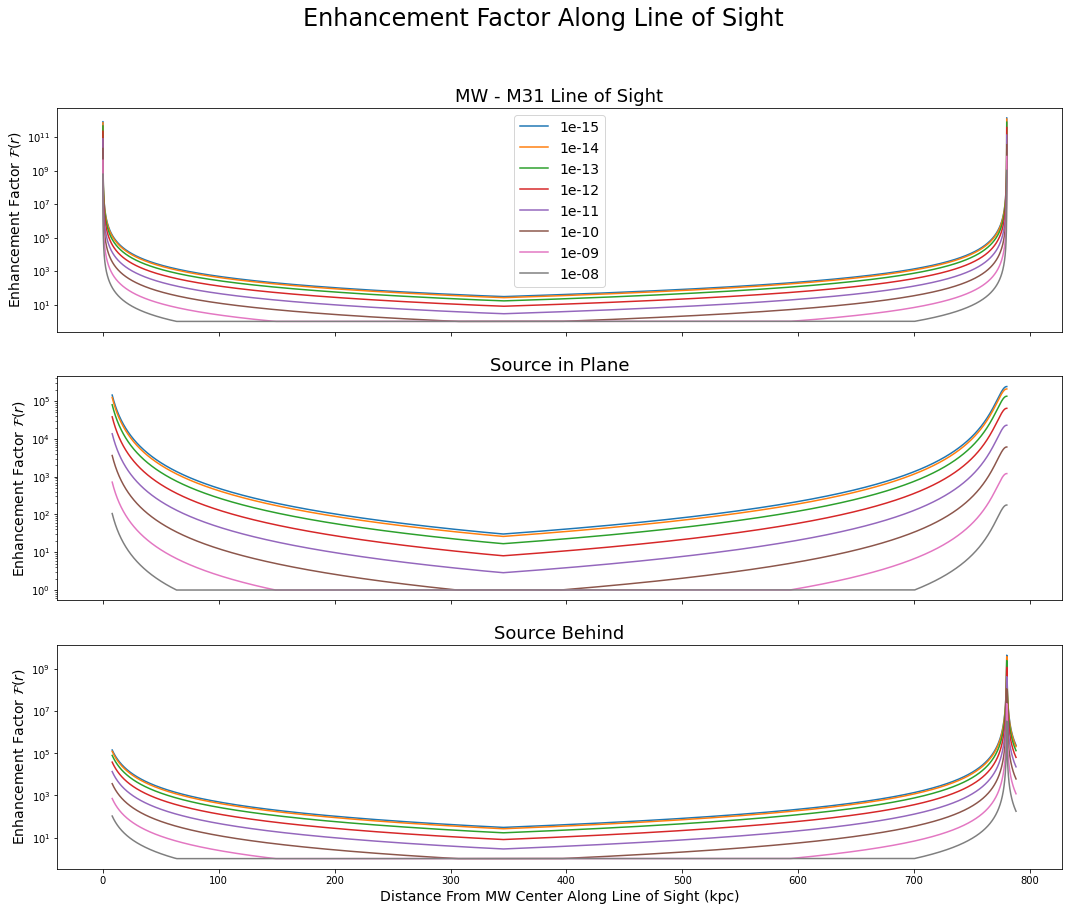

In [57]:
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(18, 14))
enhancements = [centerToCenterEventRateCalculator.results["enhancementFactor"], 
                planarEventRateCalculator.results["enhancementFactor"],
                behindEventRateCalculator.results["enhancementFactor"]]
titles = ["MW - M31 Line of Sight", "Source in Plane", "Source Behind"]
xs = [centerToCenterEventRateCalculator.results["lineOfSight"],
      planarEventRateCalculator.results["lineOfSight"],
      behindEventRateCalculator.results["lineOfSight"]]

for enhancement, title, x, ax in zip(enhancements, titles, xs, axs.ravel()):
    for f, tension in zip(enhancement, planarEventRateCalculator.tensions):
        ax.semilogy(np.linalg.norm(x, axis=0), f, label=f"{tension}")
        ax.set_title(title, fontsize=18)
        ax.set_ylabel(r"Enhancement Factor $\mathcal{F}(r)$", fontsize=14)
axs[0].legend(fontsize=14)

fig.suptitle("Enhancement Factor Along Line of Sight", fontsize=24)
axs[2].set_xlabel("Distance From MW Center Along Line of Sight (kpc)", fontsize=14)
plt.show(fig)

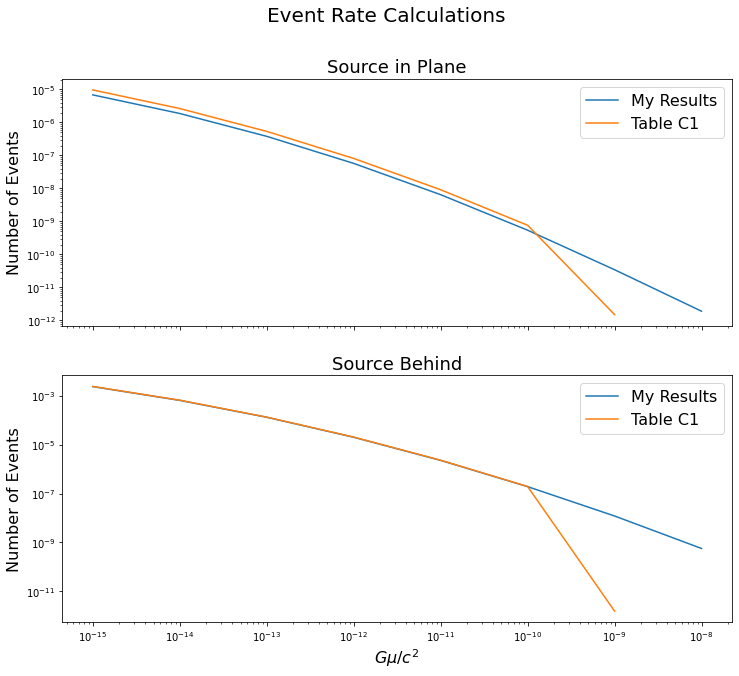

In [58]:
nEventsPlanar = (planarEventRateCalculator.results["eventRates"] * tObs).decompose()
nEventsBehind = (behindEventRateCalculator.results["eventRates"] * tObs).decompose()

fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
ys = [[nEventsPlanar, tableC1PlanarResults],
      [nEventsBehind, tableC1BackResults]]
labels = ["My Results", "Table C1"]
titles = ["Source in Plane", "Source Behind"]
for iax, (ax, t) in enumerate(zip(axs.ravel(), titles)):
    ax.set_title(t, fontsize=18)
    ax.set_ylabel("Number of Events", fontsize=16)
    for y, l, t in zip(ys[iax], labels, titles):
        ax.loglog(planarEventRateCalculator.tensions, y, label=l)
    ax.legend(fontsize=16)
axs[1].set_xlabel(r"$G\mu/c^2$", fontsize=16)
fig.suptitle("Event Rate Calculations", fontsize=20)
plt.show(fig)

In [59]:
exclusionThreshold=1e-5
planarExperimentParameters = dict(observingHoursPerNight = 10 * u.hr,
                                  sourceDistance = np.linalg.norm(planarEventRateCalculator.observerPosition - 
                                                                  planarEventRateCalculator.sourcePosition)
                                 )
planarExperimentCalculator = ExperimentExpectationsCalculator(planarExperimentParameters,
                                                              planarEventRateCalculator.tensions, 
                                                              planarEventRateCalculator.results["eventRates"])
planarExperimentCalculator.calculate(exclusionThreshold=exclusionThreshold)

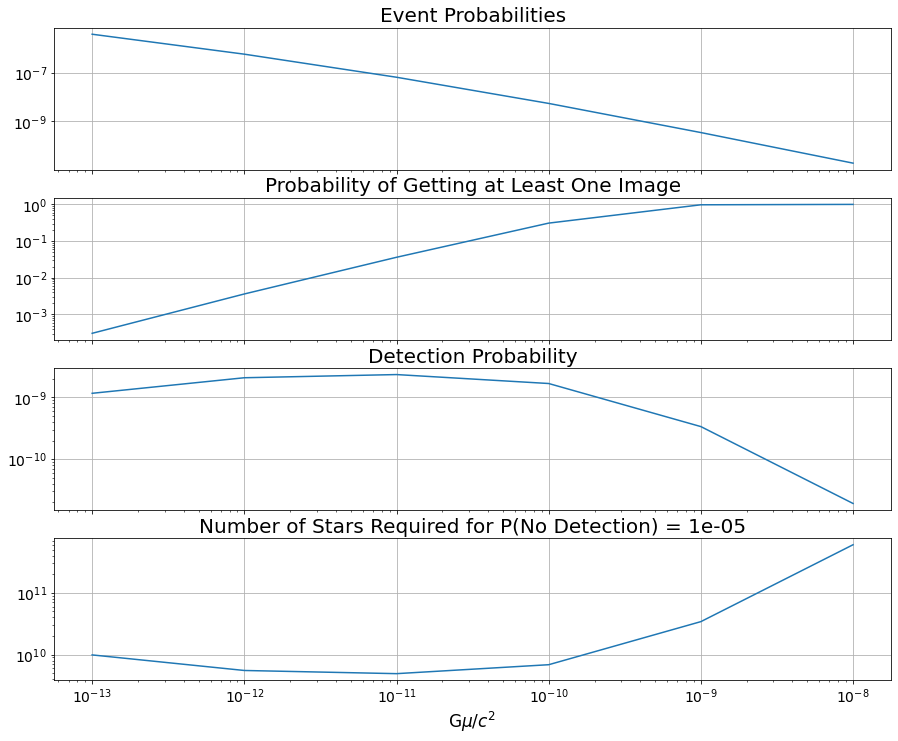

In [60]:
fig, axs = plt.subplots(4, 1, figsize=(15, 12), sharex=True)
ys = [planarExperimentCalculator.results["eventProbabilities"],
      planarExperimentCalculator.results["atLeastOneImageProbabilities"],
      planarExperimentCalculator.results["detectionProbabilities"],
      planarExperimentCalculator.results["nStarsRequired"]]
titles = ["Event Probabilities", "Probability of Getting at Least One Image",
          "Detection Probability",
          f"Number of Stars Required for P(No Detection) = {exclusionThreshold}"]
for y, t, ax in zip(ys, titles, axs.ravel()):
    ax.loglog(planarExperimentCalculator.results["probeableTensions"], y)
    ax.set_title(t, fontsize=20)
    ax.tick_params(labelsize=14)
    ax.grid(visible=True)
axs[-1].set_xlabel(r"G$\mu/c^2$", fontsize=17)
plt.show(fig)

ngc-300 Mass from [this paper](https://arxiv.org/pdf/1009.0317.pdf)

In [61]:
tensions = np.logspace(-15, -8, num=8)
curlyG = 1e4
mwHaloA = 1.15e9 * u.solMass / u.kpc**(3/4)
mwMass = 1.54e12 * u.solMass
observerPosition = np.array([0, 8]) * u.kpc
sourceBehind = np.array([8, 0]) * u.kpc
impactParameter = np.array([0, 0.1]) * u.kpc
nSteps = int(1e5)

lmcMassRatio = 10
lmcCenter = np.array([50, 0]) * u.kpc
lmcDistance = np.linalg.norm(lmcCenter)
lmcHaloR1, lmcHaloC = calculateHaloValues(lmcDistance, lmcMassRatio)

ngc300MassRatio = mwMass / (3.3e10 * u.solMass)
ngc300Center = np.array([1.86, 0]) * u.Mpc
ngc300Distance = np.linalg.norm(ngc300Center)
ngc300HaloR1, ngc300HaloC = calculateHaloValues(ngc300Distance, ngc300MassRatio)


lmcRatesConfig = dict(tensions = tensions,
                      curlyG = curlyG,
                      dmHaloA = mwHaloA,
                      dmHaloC = lmcHaloC,
                      dmHaloR1 = lmcHaloR1,
                      hostGalaxyCenter = lmcCenter,
                      observerPosition = observerPosition,
                      sourcePosition = lmcCenter + sourceBehind,
                      impactParameter = impactParameter
                      )

ngc300RatesConfig = dict(tensions = tensions,
                         curlyG = curlyG,
                         dmHaloA = mwHaloA,
                         dmHaloC = ngc300HaloC,
                         dmHaloR1 = ngc300HaloR1,
                         hostGalaxyCenter = ngc300Center,
                         observerPosition = observerPosition,
                         sourcePosition = ngc300Center + sourceBehind,
                         impactParameter = impactParameter
                         )

lmcRatesCalculator = EventRateCalculator(lmcRatesConfig)
ngc300RatesCalculator = EventRateCalculator(ngc300RatesConfig)

lmcRatesCalculator.calculate(nSteps=nSteps)
ngc300RatesCalculator.calculate(nSteps=nSteps)

In [62]:
observingHoursPerNight = 10 * u.hr
crowdedFieldExperimentDuration = 30 * u.day
crowdedFieldFilters = ["g", "r", "i", "z", "y"]
crowdedFieldVisits = np.array(5*[240])

lmcSourceDistance = np.linalg.norm(lmcRatesConfig["sourcePosition"] - lmcRatesConfig["observerPosition"])

ngc300SourceDistance = np.linalg.norm(ngc300RatesConfig["sourcePosition"] - 
                                      ngc300RatesConfig["observerPosition"])

lmcExperimentConfig = dict(observingHoursPerNight = observingHoursPerNight,
                           filters = crowdedFieldFilters,
                           visitsInEachFilter = crowdedFieldVisits,
                           experimentDuration = crowdedFieldExperimentDuration,
                           sourceDistance = lmcSourceDistance,
                           )

ngc300ExperimentConfig = dict(observingHoursPerNight = observingHoursPerNight,
                              filters = crowdedFieldFilters,
                              visitsInEachFilter = crowdedFieldVisits,
                              experimentDuration = crowdedFieldExperimentDuration,
                              sourceDistance = ngc300SourceDistance,
                              )
lmcExperimentCalculator = ExperimentExpectationsCalculator(lmcExperimentConfig, tensions,
                                                           lmcRatesCalculator.results["eventRates"])

ngc300ExperimentCalculator = ExperimentExpectationsCalculator(ngc300ExperimentConfig, tensions,
                                                              ngc300RatesCalculator.results["eventRates"])

lmcExperimentCalculator.calculate()
ngc300ExperimentCalculator.calculate()

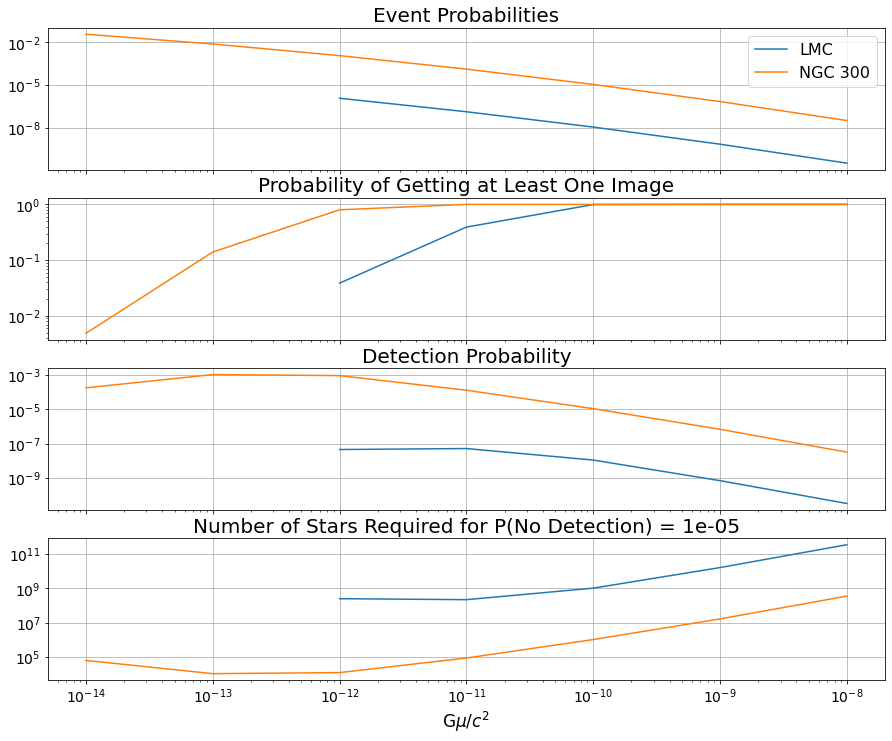

In [66]:
fig, axs = plt.subplots(4, 1, figsize=(15, 12), sharex=True)
ys = [[lmcExperimentCalculator.results["eventProbabilities"],
       ngc300ExperimentCalculator.results["eventProbabilities"]],
      [lmcExperimentCalculator.results["atLeastOneImageProbabilities"],
       ngc300ExperimentCalculator.results["atLeastOneImageProbabilities"]],
      [lmcExperimentCalculator.results["detectionProbabilities"],
       ngc300ExperimentCalculator.results["detectionProbabilities"]],
      [lmcExperimentCalculator.results["nStarsRequired"],
       ngc300ExperimentCalculator.results["nStarsRequired"]]]

titles = ["Event Probabilities", "Probability of Getting at Least One Image",
          "Detection Probability",
          f"Number of Stars Required for P(No Detection) = {exclusionThreshold}"]

labels = ["LMC", "NGC 300"]
xs = [lmcExperimentCalculator.results["probeableTensions"], 
      ngc300ExperimentCalculator.results["probeableTensions"]]

for y, t, ax in zip(ys, titles, axs.ravel()):
    for i in range(len(ys[0])):
        ax.loglog(xs[i], y[i], label=labels[i])
    ax.set_title(t, fontsize=20)
    ax.tick_params(labelsize=14)
    ax.grid(visible=True)
axs[0].legend(fontsize=16)
axs[-1].set_xlabel(r"G$\mu/c^2$", fontsize=17)
plt.show(fig)